In [8]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import StandardScaler, LabelEncoder

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('../Data/LCK_Tournament.csv')

In [33]:
#Drop columns not important
df = df.drop(['year', 'league', 'datacompleteness', 'split', 'playoffs', 'date', 'game', 'patch',
              'side', 'position', 'teamid'], axis=1)

Feature Engineering

In [34]:
# Combine all multi kills features into one
# Define the list of multi kills features to combine
multi_kills_features = ["doublekills", "triplekills", "quadrakills", "pentakills"]

# Initialize a new column to hold the combined multi kills
df["multikills"] = 0

# Iterate through each multi kills feature and add its value to the combined column
for feature in multi_kills_features:
    df["multikills"] += df[feature]

# Drop the individual multi kills features as they are now combined
df = df.drop(multi_kills_features, axis=1)


In [35]:
def calculate_team_champion_stats(data):
    """Calculate overall champion statistics for each team regardless of pick order"""
    team_champ_stats = {}
    
    # Get all pick columns
    pick_cols = [f"pick{i}" for i in range(1, 6)]
    
    # Calculate stats for each team-champion combination
    for team in data["teamname"].unique():
        team_data = data[data["teamname"] == team]
        champion_stats = {}
        
        # Combine all picks to get total champion usage
        for pick_col in pick_cols:
            for champ in team_data[pick_col].unique():
                if champ not in champion_stats:
                    champion_stats[champ] = {"games": 0, "wins": 0}
                
                champ_games = team_data[team_data[pick_col] == champ]
                champion_stats[champ]["games"] += len(champ_games)
                champion_stats[champ]["wins"] += champ_games["result"].sum()
        
        team_champ_stats[team] = champion_stats
    
    return team_champ_stats

# Calculate team-champion statistics
team_champion_stats = calculate_team_champion_stats(df)

# Add statistics columns for each pick
for i in range(1, 6):
    pick_col = f"pick{i}"
    winrate_col = f"winrate_{pick_col}"
    count_col = f"count_{pick_col}"
    
    def get_champ_stats(row):
        team_stats = team_champion_stats.get(row["teamname"], {})
        champ_stats = team_stats.get(row[pick_col], {"games": 0, "wins": 0})
        
        games = champ_stats["games"]
        winrate = champ_stats["wins"] / games if games > 0 else 0
        
        return pd.Series({
            winrate_col: winrate,
            count_col: games
        })
    
    df[[ winrate_col, count_col ]] = df.apply(get_champ_stats, axis=1)

# Display example of processed data
print("\nExample of team-champion statistics:")
print(df[["teamname", 
          "pick1", "winrate_pick1", "count_pick1",
          "pick2", "winrate_pick2", "count_pick2"]].head())

# Save processed data
df.to_csv("../Data/processed_for_prediction.csv", index=False)



Example of team-champion statistics:
            teamname   pick1  winrate_pick1  count_pick1     pick2  \
0                DRX  Lucian       0.222222          9.0   Orianna   
1  Nongshim RedForce   Milio       0.250000          8.0      Azir   
2                DRX  Lucian       0.222222          9.0      Nami   
3  Nongshim RedForce   Milio       0.250000          8.0        Vi   
4              Gen.G   Corki       0.843750         32.0  Aphelios   

   winrate_pick2  count_pick2  
0       0.000000          4.0  
1       0.176471         17.0  
2       0.200000          5.0  
3       0.444444          9.0  
4       0.750000         12.0  


In [36]:
df.head(2)

,Unnamed: 0,gameid,participantid,teamname,ban1,ban2,ban3,ban4,ban5,pick1,pick2,pick3,pick4,pick5,gamelength,result,kills,deaths,assists,firstblood,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,chemtechs,hextechs,elders,opp_elders,firstherald,heralds,opp_heralds,void_grubs,opp_void_grubs,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,goldspent,gspd,gpr,minionkills,monsterkills,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,goldat20,xpat20,csat20,opp_goldat20,opp_xpat20,opp_csat20,golddiffat20,xpdiffat20,csdiffat20,killsat20,assistsat20,deathsat20,opp_killsat20,opp_assistsat20,opp_deathsat20,goldat25,xpat25,csat25,opp_goldat25,opp_xpat25,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25,multikills,winrate_pick1,count_pick1,winrate_pick2,count_pick2,winrate_pick3,count_pick3,winrate_pick4,count_pick4,winrate_pick5,count_pick5
0,38,LOLTMNT02_22165,100,DRX,K'Sante,Kalista,LeBlanc,Skarner,Sejuani,Lucian,Orianna,Nami,Poppy,Udyr,2507,0,14,14,28,1.0,0.3351,0.6701,0.0,3.0,4.0,3.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,3.0,1.0,3.0,9.0,0.0,1.0,6.0,1.0,0.0,2.0,107963,2583.8771,3484.7387,5798.1013,139,3.3267,71,1.6992,53,357,8.5441,72714,45765,1095.2932,71150,-0.004781,1.1,1136.0,195,31.8548,16277.0,19016.0,360.0,14694.0,18973.0,317.0,1583.0,43.0,43.0,1.0,1.0,0.0,0.0,0.0,1.0,26441.0,30529.0,562.0,22526.0,29121.0,488.0,3915.0,1408.0,74.0,3.0,3.0,1.0,1.0,1.0,3.0,35781.0,43117.0,759.0,30979.0,41284.0,687.0,4802.0,1833.0,72.0,5.0,4.0,2.0,2.0,3.0,5.0,44062.0,53314.0,881.0,42714.0,56073.0,843.0,1348.0,-2759.0,38.0,8.0,13.0,5.0,5.0,10.0,8.0,0.0,0.222222,9.0,0.000000,4.0,0.2,5.0,0.00,6.0,0.000000,3.0
1,39,LOLTMNT02_22165,200,Nongshim RedForce,Ashe,Varus,Vi,Nocturne,Lee Sin,Milio,Azir,Aphelios,Jax,Gnar,2507,1,14,14,32,0.0,0.3351,0.6701,1.0,4.0,3.0,4.0,3.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0,1.0,3.0,0.0,0.0,9.0,3.0,1.0,0.0,1.0,6.0,2.0,0.0,119941,2870.5465,3444.5313,3839.4974,154,3.6857,68,1.6274,69,370,8.8552,78964,52015,1244.8744,71491,0.004781,-1.1,1124.0,260,33.1233,14694.0,18973.0,317.0,16277.0,19016.0,360.0,-1583.0,-43.0,-43.0,0.0,0.0,1.0,1.0,1.0,0.0,22526.0,29121.0,488.0,26441.0,30529.0,562.0,-3915.0,-1408.0,-74.0,1.0,1.0,3.0,3.0,3.0,1.0,30979.0,41284.0,687.0,35781.0,43117.0,759.0,-4802.0,-1833.0,-72.0,2.0,3.0,5.0,5.0,4.0,2.0,42714.0,56073.0,843.0,44062.0,53314.0,881.0,-1348.0,2759.0,-38.0,5.0,10.0,8.0,8.0,13.0,5.0,1.0,0.250000,8.0,0.176471,17.0,0.4,5.0,0.25,8.0,0.538462,13.0


In [37]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
%%writefile predictor.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

class DraftBasedPredictor:
    """
    Predicts match outcomes based on completed team drafts and historical performance
    """
    
    def __init__(self, data_path: str):
        """
        Initialize the predictor with historical match data
        
        Args:
            data_path: Path to the processed match data CSV
        """
        self.df = pd.read_csv(data_path)
        self.champion_encoders = {}
        self.model = None
        self._prepare_data()

    def _prepare_data(self):
        """Prepare and encode the draft data"""
        # Encode champions for each pick position
        for i in range(1, 6):
            pick_col = f'pick{i}'
            self.champion_encoders[pick_col] = LabelEncoder()
            self.df[f'{pick_col}_encoded'] = self.champion_encoders[pick_col].fit_transform(self.df[pick_col])

        # Create feature matrix
        self.features = [
            # Encoded picks
            'pick1_encoded', 'pick2_encoded', 'pick3_encoded', 
            'pick4_encoded', 'pick5_encoded',
            
            # Historical performance
            'winrate_pick1', 'winrate_pick2', 'winrate_pick3', 
            'winrate_pick4', 'winrate_pick5',
            
            # Pick frequency
            'count_pick1', 'count_pick2', 'count_pick3', 
            'count_pick4', 'count_pick5'
        ]

        self.X = self.df[self.features]
        self.y = self.df['result']

    def train_model(self, test_size: float = 0.2):
        """
        Train the prediction model
        
        Args:
            test_size: Proportion of data to use for testing
        """
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, 
            test_size=test_size, 
            random_state=42, 
            stratify=self.y
        )

        # Initialize and train model
        self.model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            random_state=42
        )
        
        self.model.fit(X_train, y_train)

        # Evaluate model
        y_pred = self.model.predict(X_test)
        cv_scores = cross_val_score(self.model, X_train, y_train, cv=5)

        # Print performance metrics
        print("\nModel Performance Metrics:")
        print(f"Cross-validation score: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot feature importance
        self._plot_feature_importance()

    def _plot_feature_importance(self):
        """Visualize feature importance"""
        importance = pd.DataFrame({
            'feature': self.features,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=importance.head(10), x='importance', y='feature')
        plt.title('Top 10 Most Important Features for Prediction')
        plt.tight_layout()
        plt.show()

    def get_champion_stats(self, team_name: str, picks: list[str]) -> list[dict]:
        """
        Get detailed statistics for each champion pick
        
        Args:
            team_name: Name of the team
            picks: List of champion picks
            
        Returns:
            List of dictionaries containing champion statistics
        """
        stats = []
        for i, pick in enumerate(picks, 1):
            # Get team-specific stats for specific pick order
            team_pick_stats = self.df[
                (self.df['teamname'] == team_name) & 
                (self.df[f'pick{i}'] == pick)
            ]
            
            # Get overall stats for specific pick order
            overall_stats = self.df[self.df[f'pick{i}'] == pick]
            
            # Get team stats for this champion regardless of pick order
            team_all_pick_stats = self.df[
                (self.df['teamname'] == team_name) & 
                (self.df[['pick1', 'pick2', 'pick3', 'pick4', 'pick5']] == pick).any(axis=1)
            ]
            
            # Get overall stats for this champion regardless of pick order
            overall_all_pick_stats = self.df[
                (self.df[['pick1', 'pick2', 'pick3', 'pick4', 'pick5']] == pick).any(axis=1)
            ]
            
            stats.append({
                'position': i,
                'champion': pick,
                # Stats for specific pick order
                'team_games': len(team_pick_stats) if not team_pick_stats.empty else 0,
                'team_winrate': team_pick_stats['result'].mean() if not team_pick_stats.empty else 0,
                'overall_games': len(overall_stats) if not overall_stats.empty else 0,
                'overall_winrate': overall_stats['result'].mean() if not overall_stats.empty else 0,
                # Stats regardless of pick order
                'team_all_pick_games': len(team_all_pick_stats) if not team_all_pick_stats.empty else 0,
                'team_all_pick_winrate': team_all_pick_stats['result'].mean() if not team_all_pick_stats.empty else 0,
                'overall_all_pick_games': len(overall_all_pick_stats) if not overall_all_pick_stats.empty else 0,
                'overall_all_pick_winrate': overall_all_pick_stats['result'].mean() if not overall_all_pick_stats.empty else 0
            })
        
        return stats
    

    def predict_match(self, 
                     team1_name: str,
                     team1_picks: list[str],
                     team2_name: str,
                     team2_picks: list[str]) -> dict:
        """
        Predict match outcome based on completed drafts
        
        Args:
            team1_name: Name of first team
            team1_picks: List of 5 champions picked by team1
            team2_name: Name of second team
            team2_picks: List of 5 champions picked by team2
            
        Returns:
            Dictionary containing prediction details
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train_model() first.")

        # Validate inputs
        if len(team1_picks) != 5 or len(team2_picks) != 5:
            raise ValueError("Each team must have exactly 5 picks")

        # Process team drafts
        team1_features = self._process_team_draft(team1_name, team1_picks)
        team2_features = self._process_team_draft(team2_name, team2_picks)

        # Get win probabilities
        team1_prob = self.model.predict_proba([team1_features])[0][1]
        team2_prob = self.model.predict_proba([team2_features])[0][1]

        # Normalize probabilities
        total = team1_prob + team2_prob
        team1_prob /= total
        team2_prob /= total

        # Create result dictionary
        result = {
            'team1': {
                'name': team1_name,
                'picks': team1_picks,
                'win_probability': team1_prob,
                'champion_stats': self.get_champion_stats(team1_name, team1_picks)
            },
            'team2': {
                'name': team2_name,
                'picks': team2_picks,
                'win_probability': team2_prob,
                'champion_stats': self.get_champion_stats(team2_name, team2_picks)
            }
            
        }

        return result

    def print_detailed_prediction(self, result: dict):
        """
        Print detailed prediction results including champion statistics
        
        Args:
            result: Prediction result dictionary
        """
        print("\n=== Match Prediction ===")
        print(f"\nOverall Win Probabilities:")
        print(f"{result['team1']['name']}: {result['team1']['win_probability']:.1%}")
        print(f"{result['team2']['name']}: {result['team2']['win_probability']:.1%}")
        
        print("\n=== Champion Statistics ===")
        
        # Print team-specific champion stats
        for team in ['team1', 'team2']:
            print(f"\n{result[team]['name']} Draft:")
            for stat in result[team]['champion_stats']:
                print(f"\nPosition {stat['position']} - {stat['champion']}:")
                print(f"  Team Stats (Pick {stat['position']}) : {stat['team_winrate']:.1%} win rate ({stat['team_games']} games)")
                print(f"  Team Stats (All Picks)     : {stat['team_all_pick_winrate']:.1%} win rate ({stat['team_all_pick_games']} games)")
                print(f"  Overall Stats (Pick {stat['position']}) : {stat['overall_winrate']:.1%} win rate ({stat['overall_games']} games)")
                print(f"  Overall Stats (All Picks)   : {stat['overall_all_pick_winrate']:.1%} win rate ({stat['overall_all_pick_games']} games)")
        
    def _process_team_draft(self, team_name: str, picks: list[str]) -> list:
        """Process draft picks into model features"""
        features = []

        # Encode picks
        for i, pick in enumerate(picks, 1):
            try:
                encoded_pick = self.champion_encoders[f'pick{i}'].transform([pick])[0]
                features.append(encoded_pick)
            except ValueError:
                raise ValueError(f"Unknown champion '{pick}' for {team_name}'s pick {i}")

        # Get historical performance stats
        for i, pick in enumerate(picks, 1):
            team_pick_stats = self.df[
                (self.df['teamname'] == team_name) & 
                (self.df[f'pick{i}'] == pick)
            ]
            
            winrate = team_pick_stats[f'winrate_pick{i}'].mean() if not team_pick_stats.empty else 0
            count = team_pick_stats[f'count_pick{i}'].mean() if not team_pick_stats.empty else 0
            
            features.extend([winrate, count])

        return features

Writing predictor.py



Model Performance Metrics:
Cross-validation score: 0.807 (+/- 0.056)

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        97
           1       0.81      0.82      0.81        96

    accuracy                           0.81       193
   macro avg       0.81      0.81      0.81       193
weighted avg       0.81      0.81      0.81       193



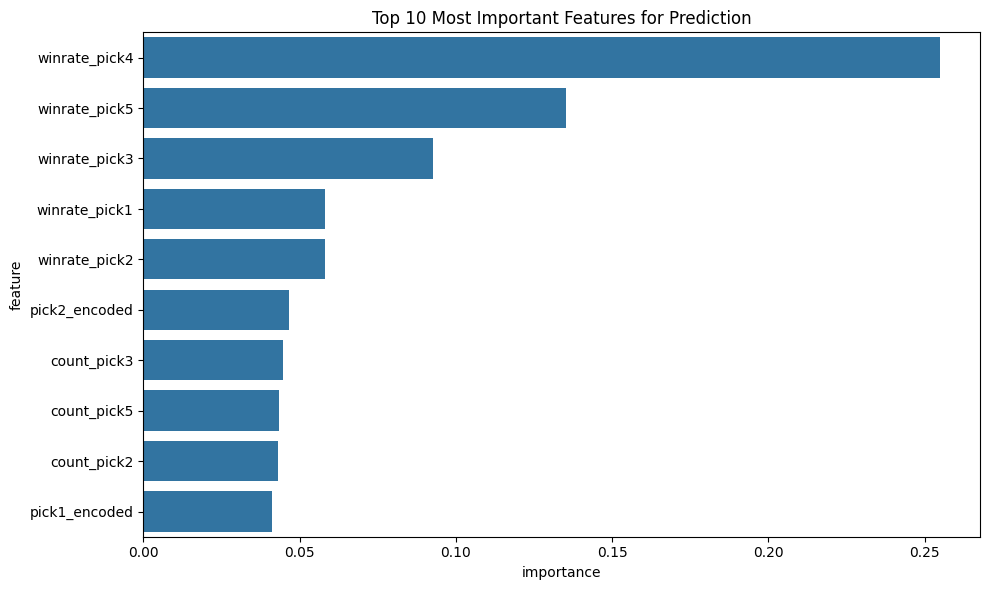


=== Match Prediction ===

Overall Win Probabilities:
T1: 50.1%
Gen.G: 49.9%

=== Champion Statistics ===

T1 Draft:

Position 1 - Twisted Fate:
  Team Stats (Pick 1) : 0.0% win rate (2 games)
  Team Stats (All Picks)     : 54.5% win rate (11 games)
  Overall Stats (Pick 1) : 0.0% win rate (2 games)
  Overall Stats (All Picks)   : 64.9% win rate (37 games)

Position 2 - Tahm Kench:
  Team Stats (Pick 2) : 100.0% win rate (2 games)
  Team Stats (All Picks)     : 100.0% win rate (8 games)
  Overall Stats (Pick 2) : 66.7% win rate (12 games)
  Overall Stats (All Picks)   : 61.5% win rate (39 games)

Position 3 - Senna:
  Team Stats (Pick 3) : 100.0% win rate (1 games)
  Team Stats (All Picks)     : 77.3% win rate (22 games)
  Overall Stats (Pick 3) : 100.0% win rate (1 games)
  Overall Stats (All Picks)   : 67.0% win rate (88 games)

Position 4 - Lee Sin:
  Team Stats (Pick 4) : 100.0% win rate (1 games)
  Team Stats (All Picks)     : 20.0% win rate (10 games)
  Overall Stats (Pick 4) : 5

In [57]:
# Example usage:
if __name__ == "__main__":
    predictor = DraftBasedPredictor("../Data/processed_for_prediction.csv")
    predictor.train_model()
    
    result = predictor.predict_match(
        team1_name="T1",
        team1_picks=["Twisted Fate", "Tahm Kench", "Senna", "Lee Sin", "Ahri"],
        team2_name="Gen.G",
        team2_picks=["Lucian", "Nami", "K'Sante", "Sejuani", "Tristana"]
    )
    
    predictor.print_detailed_prediction(result)
    


Model Performance Metrics:
Cross-validation score: 0.807 (+/- 0.056)

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        97
           1       0.81      0.82      0.81        96

    accuracy                           0.81       193
   macro avg       0.81      0.81      0.81       193
weighted avg       0.81      0.81      0.81       193



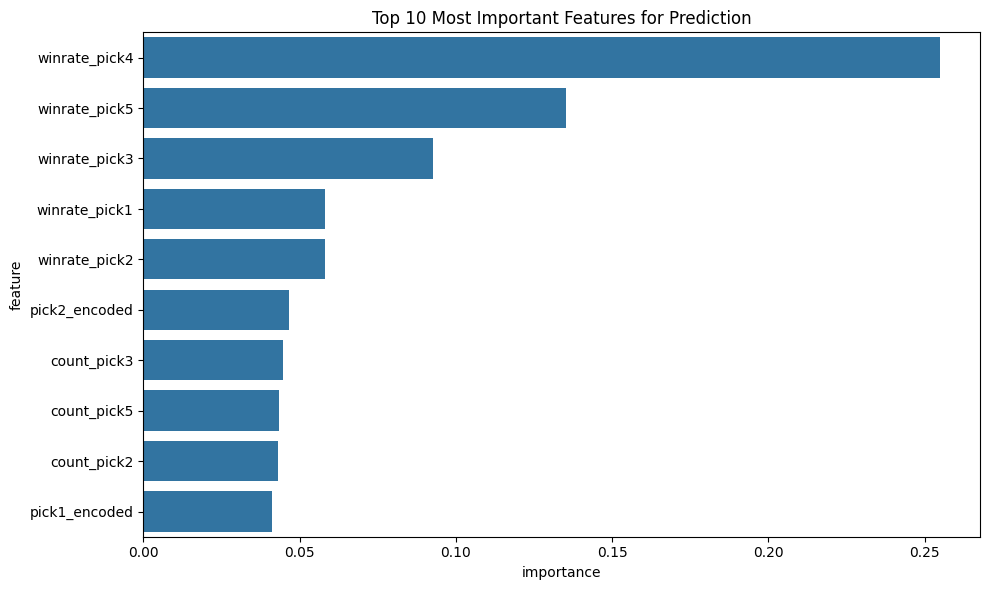

Model saved successfully!


In [61]:
import joblib

def train_and_save_model():
    # Initialize and train the model
    predictor = DraftBasedPredictor("../Data/processed_for_prediction.csv")
    predictor.train_model()
    
    # Save the trained model and necessary data
    joblib.dump(predictor, '../Models/draft_predictor.joblib')
    print("Model saved successfully!")
    
train_and_save_model()
